
# Recommendation A/B Testing: Experimentation with Imperfect Compliance

(This tutorial is adapted from the EconML website - I am trying to test the use of the DoubleML and the EconML package to do customer segmentation)

Problem statement: An online business would like to test a new feature or offering of their website and learn its effect on downstream revenue. Furthermore, they would like to know which kind of users respond best to the new version. We call the user-specfic effect a heterogeneous treatment effect.

Ideally, the business would run an A/B tests between the old and new versions of the website. However, a direct A/B test might not work because the business cannot force the customers to take the new offering. Measuring the effect in this way will be misleading since not every customer exposed to the new offering will take it.

The business also cannot look directly at existing data as it will be biased: the users who use the latest website features are most likely the ones who are very engaged on the website and hence spend more on the company's products to begin with. Estimating the effect this way would be overly optimistic.

This tutorial shows how Causal inference with ML techniques can be used in conjunction with A/B tests

In [13]:
# Some imports to get us started
# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd

# Generic ML imports
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures

# EconML imports
from econml.iv.dr import LinearIntentToTreatDRIV
from econml.cate_interpreter import SingleTreeCateInterpreter, \
                                    SingleTreePolicyInterpreter

import matplotlib.pyplot as plt
%matplotlib inline


## Methodology description 
A direct A/B test is infeasible because the website cannot force users to become members. Likewise, the travel company can’t look directly at existing data, comparing members and non-members, because the customers who chose to become members are likely already more engaged than other users.

The solution: The company had run an earlier experiment to test the value of a new, faster sign-up process. EconML's IV estimators can exploit this experimental nudge towards membership as an instrument that generates random variation in the likelihood of membership. This is known as an intent-to-treat setting: the intention is to give a random group of user the "treatment" (access to the easier sign-up process), but not not all users will actually take it. 

[Note this is a classic IV approach, so there is nothing new here. The IV (those who were exposed to sign-up process) must be highly correlated with those who are members, which is likely to be true in this case. At the same time, it is not meant to be correlated with time spent on the app. This is also true given the fact that the allocation of the faster sign-up process is supposed to be random.]

EconML's IntentToTreatDRIV estimator model takes advantage of the fact that not every customer who was offered the easier sign-up became a member to learn the effect of membership rather than the effect of receiving the quick sign-up.

# Data

The data* is comprised of:
 * Features collected in the 28 days prior to the experiment (denoted by the suffix `_pre`)
 * Experiment variables (whether the use was exposed to the easier signup -> the instrument, and whether the user became a member -> the treatment)
 * Variables collected in the 28 days after the experiment (denoted by the suffix `_post`).

Feature Name | Type | Details 
:--- |:--- |:--- 
**days_visited_exp_pre** | X | #days a user visits the attractions pages 
**days_visited_free_pre** | X | #days a user visits the website through free channels (e.g. domain direct) 
**days_visited_fs_pre** | X | #days a user visits the flights pages 
**days_visited_hs_pre** | X | #days a user visits the hotels pages 
**days_visited_rs_pre** | X | #days a user visits the restaurants pages 
**days_visited_vrs_pre** | X |#days a user visits the vacation rental pages 
**locale_en_US** | X | whether the user access the website from the US 
**os_type** | X | user's operating system (windows, osx, other) 
**revenue_pre** | X | how much the user spent on the website in the pre-period 
**easier_signup** | Z | whether the user was exposed to the easier signup process 
**became_member** | T | whether the user became a member 
**days_visited_post** | Y | #days a user visits the website in the 28 days after the experiment 


**To protect the privacy of the travel company's users, the data used in this scenario is synthetically generated and the feature distributions don't correspond to real distributions. However, the feature names have preserved their names and meaning.*

In [6]:
# We use a sample data from the online business
file_url = "https://msalicedatapublic.z5.web.core.windows.net/datasets/RecommendationAB/ab_sample.csv"   
ab_data = pd.read_csv(file_url)

In [7]:
# Data sample
ab_data.head()

,days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows,easier_signup,became_member,days_visited_post
0,1,9,7,25,6,3,1,0.01,0,1,0,0,1
1,10,25,27,10,27,27,0,2.26,0,0,0,0,15
2,18,14,8,4,5,2,1,0.03,0,1,0,0,17
3,17,0,23,2,3,1,1,418.77,0,1,0,0,6
4,24,9,22,2,3,18,1,1.54,0,0,0,0,12


In [9]:
# Define estimator inputs
Z = ab_data['easier_signup'] # nudge, or instrument
T = ab_data['became_member'] # intervention, or treatment
Y = ab_data['days_visited_post'] # outcome of interest
X_data = ab_data.drop(columns=['easier_signup', 'became_member', 'days_visited_post']) # features

The data was generated using the following undelying treatment effect function:

$$
\text{treatment_effect} = 0.2 + 0.3 \cdot \text{days_visited_free_pre} - 0.2 \cdot \text{days_visited_hs_pre} + \text{os_type_osx}
$$

The interpretation of this is that users who visited the website before the experiment and/or who use an iPhone tend to benefit from the membership program, whereas users who visited the hotels pages tend to be harmed by membership. **This is the relationship we seek to learn from the data.**

In [10]:
# Define underlying treatment effect function 
TE_fn = lambda X: (0.2 + 0.3 * X['days_visited_free_pre'] - 0.2 * X['days_visited_hs_pre'] + X['os_type_osx']).values
true_TE = TE_fn(X_data)

# Define the true coefficients to compare with
true_coefs = np.zeros(X_data.shape[1])
true_coefs[[1, 3, -2]] = [0.3, -0.2, 1]

# Get Causal Effects with EconML

To learn a linear projection of the treatment effect, we use the `LinearIntentToTreatDRIV` EconML estimator. For a more flexible treatment effect function, use the `IntentToTreatDRIV` estimator instead. 

The model requires to define some nuissance models (i.e. models we don't really care about but that matter for the analysis): the model for how the outcome $Y$ depends on the features $X$ (`model_Y_X`) and the model for how the treatment $T$ depends on the instrument $Z$ and features $X$ (`model_T_XZ`). Since we don't have any priors on these models, we use generic boosted tree estimators to learn them. 


In [14]:
# Define nuissance estimators
lgb_T_XZ_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}

lgb_Y_X_params = {
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}
model_T_XZ = lgb.LGBMClassifier(**lgb_T_XZ_params)
model_Y_X = lgb.LGBMRegressor(**lgb_Y_X_params)
flexible_model_effect = lgb.LGBMRegressor(**lgb_Y_X_params)

In [15]:
# Train EconML model
model = LinearIntentToTreatDRIV(
    model_y_xw = model_Y_X,
    model_t_xwz = model_T_XZ,
    flexible_model_effect = flexible_model_effect,
    featurizer = PolynomialFeatures(degree=1, include_bias=False)
)
model.fit(Y, T, Z=Z, X=X_data, inference="statsmodels")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 66666, number of used features: 10
[LightGBM] [Info] Start training from score 9.935424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [16]:
# Compare learned coefficients with true model coefficients
coef_indices = np.arange(model.coef_.shape[0])
# Calculate error bars
coef_error = np.asarray(model.coef__interval()) # 95% confidence interval for coefficients
coef_error[0, :] = model.coef_ - coef_error[0, :]
coef_error[1, :] = coef_error[1, :] - model.coef_

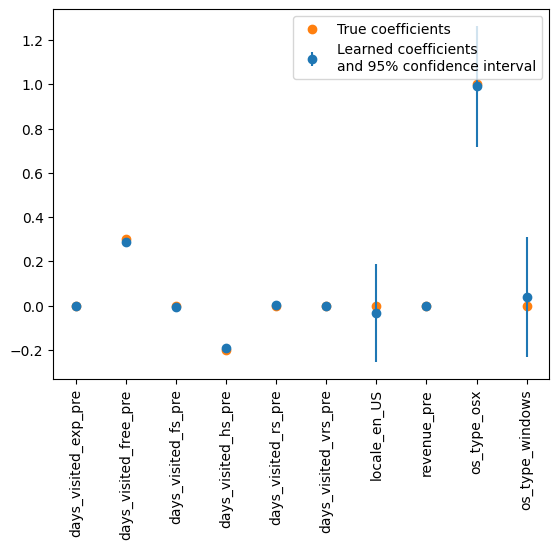

In [19]:
plt.errorbar(coef_indices, model.coef_, coef_error, fmt="o", label="Learned coefficients\nand 95% confidence interval")
plt.scatter(coef_indices, true_coefs, color='C1', label="True coefficients")
plt.xticks(coef_indices, X_data.columns, rotation='vertical')
plt.legend()
plt.show() ## The learned coefficients are pretty close to the true coefficients

In [18]:
model.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
days_visited_exp_pre,-0.0,0.007,-0.073,0.942,-0.014,0.013
days_visited_free_pre,0.286,0.007,38.494,0.0,0.271,0.301
days_visited_fs_pre,-0.008,0.007,-1.128,0.259,-0.021,0.006
days_visited_hs_pre,-0.191,0.007,-28.134,0.0,-0.204,-0.177
days_visited_rs_pre,0.002,0.007,0.226,0.821,-0.012,0.015
days_visited_vrs_pre,-0.001,0.007,-0.084,0.933,-0.014,0.013
locale_en_US,-0.034,0.113,-0.298,0.766,-0.256,0.188
revenue_pre,-0.0,0.0,-1.202,0.229,-0.0,0.0
os_type_osx,0.991,0.139,7.143,0.0,0.719,1.263
os_type_windows,0.039,0.138,0.282,0.778,-0.232,0.31


In [20]:
test_customers = X_data.iloc[:1000]
true_customer_TE = TE_fn(test_customers)
model_customer_TE = model.effect(test_customers)

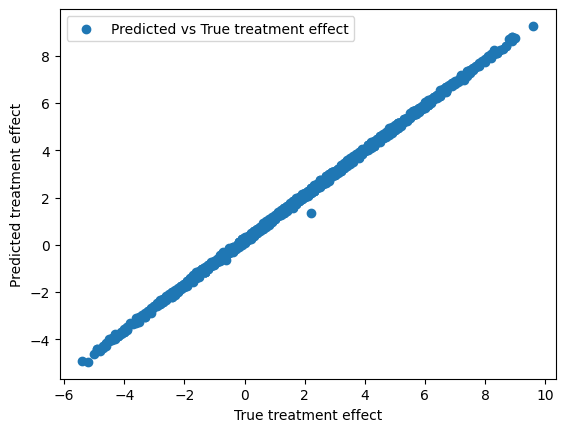

In [21]:
# How close are the predicted treatment effect to the true treatment effects for 1000 users?
plt.scatter(true_customer_TE, model.effect(test_customers), label="Predicted vs True treatment effect")
plt.xlabel("True treatment effect")
plt.ylabel("Predicted treatment effect")
plt.legend()
plt.show()

# Understand Treatment Effects with EconML

(Typically, ML algorithms are pretty hard to interpret as we won't know what variables are driving these treatment effects. We therefore look at various approaches to demystify the ML modles)

EconML includes interpretability tools to better understand treatment effects. Treatment effects can be complex, but oftentimes we are interested in simple rules that can differentiate between users who respond positively, users who remain neutral and users who respond negatively to the proposed changes.

The EconML `SingleTreeCateInterpreter` provides interperetability by training a single decision tree on the treatment effects outputted by the any of the EconML estimators. In the figure below we can see in dark red users who respond negatively to the membership program and in dark green users who respond positively.

X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names


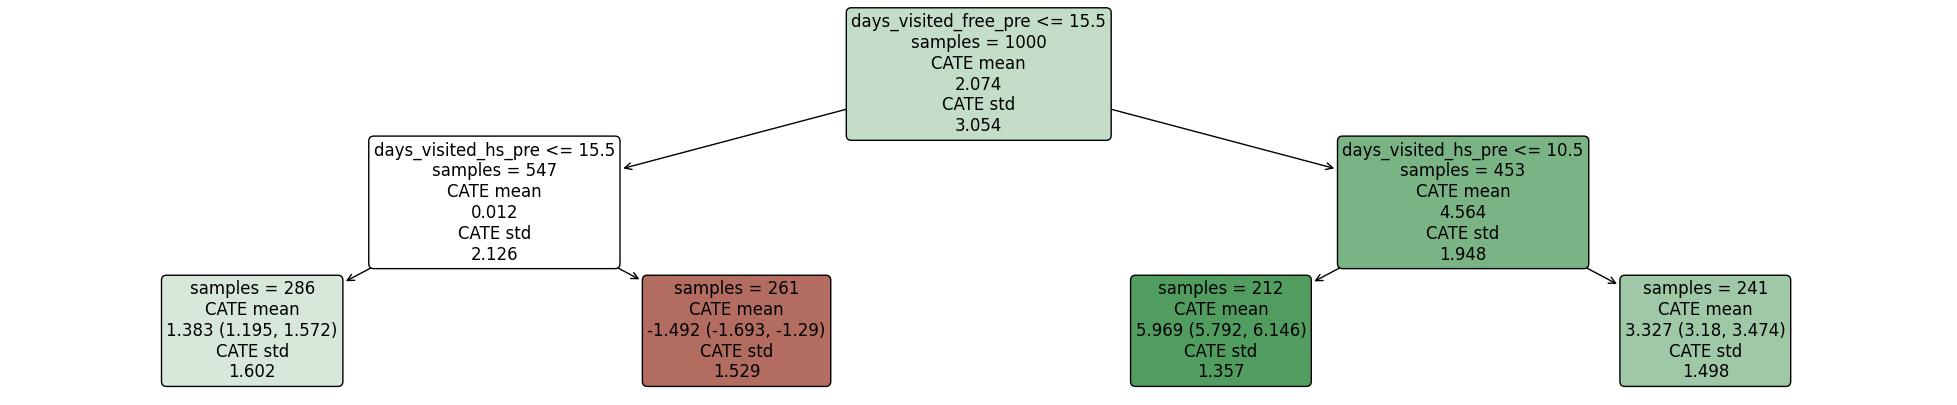

In [23]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(model, test_customers)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X_data.columns, fontsize=12) ## clearly, days since visiting via free channels and via hotels are very important variables